<a href="https://colab.research.google.com/github/MuskanSinhaPi/Intern/blob/main/LSTM_(simplified_STHSL)_with_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install google.colab
from google.colab import drive
import pandas as pd

#mounting drive
drive.mount('/content/drive')
# reading data
sf_crime=pd.read_csv("/content/drive/MyDrive/internship/Datasets/San Francisco Crime/SFCrime.csv")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.2 MB/s eta 0:00:00
Mounted at /content/drive


<ipython-input-1-8b48e36a179a>:8: DtypeWarning: Columns (0,29) have mixed types. Specify dtype option on import or set low_memory=False.
  sf_crime=pd.read_csv("/content/drive/MyDrive/internship/Datasets/San Francisco Crime/SFCrime.csv")


###Feature Engineering

In [ ]:
sf_crime = sf_crime[['Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict','Resolution', 'Address', 'X','Y']]

#Data Cleaning

# Drop rows with any missing values
sf_crime.dropna(inplace=True)
print(sf_crime.isnull().sum())

Category      0
Descript      0
DayOfWeek     0
Date          0
Time          0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64


In [ ]:
# Convert 'Date' and 'Time' columns to datetime because we can only use .dt accessor with datetimelike values
sf_crime['datetime'] = pd.to_datetime(sf_crime['Date'] + ' ' + sf_crime['Time'])

# Extract relevant features
sf_crime['year'] = sf_crime['datetime'].dt.year
sf_crime['hour'] = sf_crime['datetime'].dt.hour
sf_crime['month'] = sf_crime['datetime'].dt.month
sf_crime['day_of_week'] = sf_crime['datetime'].dt.dayofweek
sf_crime['day'] = pd.to_datetime(sf_crime['datetime']).dt.day
sf_crime['minute'] = pd.to_datetime(sf_crime['datetime']).dt.minute

In [ ]:
# Filter data for years before 2018 for training and use 2018 for testing
train_df = sf_crime[sf_crime['year'] < 2018]
test_df = sf_crime[sf_crime['year'] == 2018]

In [ ]:
# Create a mapping dictionary for the new categories
category_mapping = {
    'ROBBERY': 'Violent Crimes',
    'VEHICLE THEFT': 'Property Crimes',
    'ARSON': 'Violent Crimes',
    'ASSAULT': 'Violent Crimes',
    'TRESPASS': 'Miscellaneous',
    'BURGLARY': 'Property Crimes',
    'LARCENY/THEFT': 'Property Crimes',
    'WARRANTS': 'Administrative and Other Offenses',
    'OTHER OFFENSES': 'Administrative and Other Offenses',
    'DRUG/NARCOTIC': 'Drug and Alcohol Related',
    'SUSPICIOUS OCC': 'Miscellaneous',
    'LIQUOR LAWS': 'Drug and Alcohol Related',
    'VANDALISM': 'Property Crimes',
    'WEAPON LAWS': 'Violent Crimes',
    'NON-CRIMINAL': 'Non-Criminal and Special Cases',
    'MISSING PERSON': 'Non-Criminal and Special Cases',
    'FRAUD': 'Property Crimes',
    'SEX OFFENSES, FORCIBLE': 'Violent Crimes',
    'SECONDARY CODES': 'Administrative and Other Offenses',
    'DISORDERLY CONDUCT': 'Public Order Crimes',
    'RECOVERED VEHICLE': 'Non-Criminal and Special Cases',
    'KIDNAPPING': 'Violent Crimes',
    'FORGERY/COUNTERFEITING': 'Property Crimes',
    'PROSTITUTION': 'Public Order Crimes',
    'DRUNKENNESS': 'Drug and Alcohol Related',
    'BAD CHECKS': 'White Collar Crimes',
    'DRIVING UNDER THE INFLUENCE': 'Drug and Alcohol Related',
    'LOITERING': 'Public Order Crimes',
    'STOLEN PROPERTY': 'Property Crimes',
    'SUICIDE': 'Non-Criminal and Special Cases',
    'BRIBERY': 'White Collar Crimes',
    'EXTORTION': 'White Collar Crimes',
    'EMBEZZLEMENT': 'Property Crimes',
    'GAMBLING': 'Public Order Crimes',
    'PORNOGRAPHY/OBSCENE MAT': 'Non-Criminal and Special Cases',
    'SEX OFFENSES, NON FORCIBLE': 'Violent Crimes',
    'TREA': 'Non-Criminal and Special Cases'
}


# Replace the original 'Category' column with the new categories
sf_crime['Category'] = sf_crime['Category'].map(category_mapping)
train_df['Category'] = train_df['Category'].map(category_mapping)
test_df['Category'] = test_df['Category'].map(category_mapping)

<ipython-input-5-e98a2420c080>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Category'] = train_df['Category'].map(category_mapping)
<ipython-input-5-e98a2420c080>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Category'] = test_df['Category'].map(category_mapping)


In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [ ]:
label_encoder = LabelEncoder()

# Encode 'Category' (target variable)
train_df['Category'] = label_encoder.fit_transform(train_df['Category'])
test_df['Category'] = label_encoder.transform(test_df['Category'])

<ipython-input-7-9c2db736ad87>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Category'] = label_encoder.fit_transform(train_df['Category'])
<ipython-input-7-9c2db736ad87>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Category'] = label_encoder.transform(test_df['Category'])


In [ ]:
# Define the features and target variable
features = ['PdDistrict','hour','day','minute','day_of_week', 'month', 'X', 'Y']
X_train = train_df[features]
y_train = train_df['Category']
X_test = test_df[features]
y_test = test_df['Category']

# One-hot encode the 'PdDistrict' feature
X_train = pd.get_dummies(X_train, columns=['PdDistrict'])
X_test = pd.get_dummies(X_test, columns=['PdDistrict'])

# Ensure the columns match between train and test sets
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
from sklearn import preprocessing as prepro
from keras.layers import Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam
from collections import Counter
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Convert y to categorical (assuming y is numeric)
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Preprocessing and Standardize X_train and X_test
X_train = prepro.StandardScaler().fit_transform(X_train)
X_test = prepro.StandardScaler().fit_transform(X_test)

# Convert y_train to a NumPy array of floating-point values
y_train_float = y_train.astype(np.float32)

# Convert y_train to a Tensor
y_train_tensor = tf.convert_to_tensor(y_train_float)

In [ ]:
model=Sequential()
# model.add(Embedding(50000,100,input_length=3000))  # Input as the number of words (vocabulary size)
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))  #Softmax for multiclass
model.add(Dense(y_train_categorical.shape[1], activation='softmax'))

# Compile the model
model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='adam')

# Ensure that y_train_categorical and y_test_categorical are numpy arrays
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Convert y_train to a Tensor
y_train_tensor = tf.convert_to_tensor(y_train_categorical)

# Reshape X_train and X_test to be 3D (samples, timesteps, features)
# Assuming each sample should be treated as a single timestep
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Train the model
history = model.fit(X_train_reshaped, y_train_tensor, validation_data=(X_test_reshaped, y_test_categorical), batch_size=64, epochs=8, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/8
18636/18636 [==============================] - 127s 6ms/step - loss: 1.5447 - accuracy: 0.4244 - val_loss: 1.8111 - val_accuracy: 0.3699
Epoch 2/8
18636/18636 [==============================] - 121s 6ms/step - loss: 1.5167 - accuracy: 0.4348 - val_loss: 1.9154 - val_accuracy: 0.3604
Epoch 3/8
18636/18636 [==============================] - 114s 6ms/step - loss: 1.5076 - accuracy: 0.4382 - val_loss: 1.9542 - val_accuracy: 0.3550
Epoch 4/8
18636/18636 [==============================] - 113s 6ms/step - loss: 1.5017 - accuracy: 0.4401 - val_loss: 1.9836 - val_accuracy: 0.3509


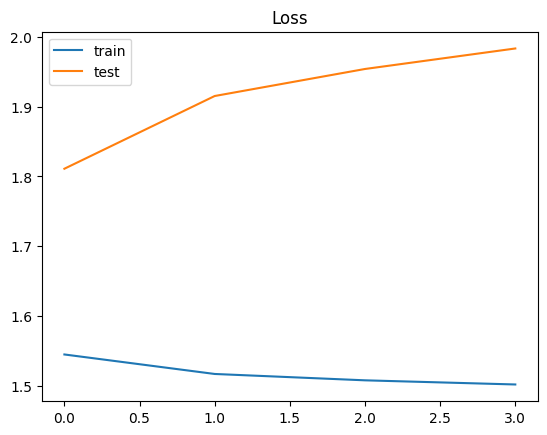

In [ ]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

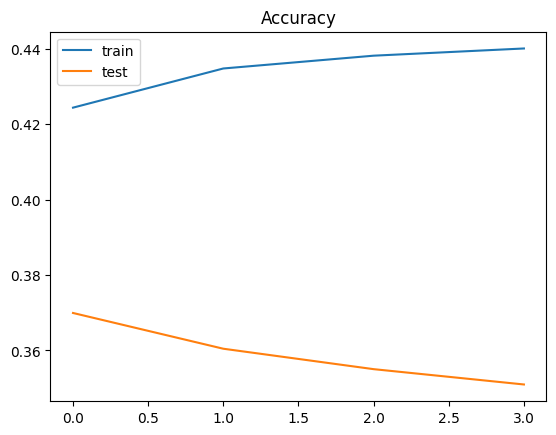

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.metrics import accuracy_score

# # Define the STHSL model
# class STHSLModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(STHSLModel, self).__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         h_lstm, _ = self.lstm(x)
#         h_lstm = h_lstm[:, -1, :]  # Take the output of the last time step
#         out = self.fc(h_lstm)
#         return out

# # Prepare data for the model
# def prepare_sequences(data, seq_length=10):
#     sequences = []
#     targets = []
#     for i in range(len(data) - seq_length):
#         seq = data[i:i+seq_length]
#         target = data[i+seq_length, -1]
#         sequences.append(seq)
#         targets.append(target)
#     return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.long)

# # Convert data to sequences
# X_train_seq, y_train_seq = prepare_sequences(X_train.values)
# X_test_seq, y_test_seq = prepare_sequences(X_test.values)

# # Create DataLoader
# train_dataset = TensorDataset(X_train_seq, y_train_seq)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# test_dataset = TensorDataset(X_test_seq, y_test_seq)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# # Model parameters
# input_dim = X_train_seq.shape[2]  # Number of features
# hidden_dim = 128
# output_dim = len(label_encoder.classes_)

# # Instantiate the model
# model = STHSLModel(input_dim, hidden_dim, output_dim)

# # Training setup
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # # Training loop
# # num_epochs = 10  # Adjust the number of epochs as needed
# # for epoch in range(num_epochs):
# #     model.train()
# #     for inputs, labels in train_loader:
# #         optimizer.zero_grad()
# #         outputs = model(inputs)
# #         loss = criterion(outputs, labels)
# #         loss.backward()
# #         optimizer.step()
# #     print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# # # Evaluation
# # model.eval()
# # all_preds = []
# # all_labels = []
# # with torch.no_grad():
# #     for inputs, labels in test_loader:
# #         outputs = model(inputs)
# #         preds = outputs.argmax(dim=1)
# #         all_preds.extend(preds.numpy())
# #         all_labels.extend(labels.numpy())

# # # Calculate accuracy
# # accuracy = accuracy_score(all_labels, all_preds)
# # print(f'Accuracy: {accuracy}')
# # Training loop with error printing
# num_epochs = 1
# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()

#     # Calculate average training loss
#     train_loss /= len(train_loader)

#     # Calculate training accuracy
#     model.eval()
#     all_probs = []  # Store probabilities instead of just predictions
#     all_labels = []
#     with torch.no_grad():
#         for inputs, labels in train_loader:
#             outputs = model(inputs)
#             probs = torch.softmax(outputs, dim=1)  # Calculate probabilities
#             all_probs.append(probs.numpy())
#             all_labels.extend(labels.numpy())

#     # Flatten the probabilities and labels
#     all_probs = np.concatenate(all_probs, axis=0)
#     all_labels = np.array(all_labels)

#     # Determine predicted class based on a threshold (e.g., 0.5)
#     threshold = 0.5
#     all_preds = (all_probs > threshold).astype(int)

#     train_accuracy = accuracy_score(all_labels, all_preds)

#     # Calculate test accuracy
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             outputs = model(inputs)
#             probs = torch.softmax(outputs, dim=1)
#             all_probs.append(probs.numpy())
#             all_labels.extend(labels.numpy())

#     # Flatten the probabilities and labels
#     all_probs = np.concatenate(all_probs, axis=0)
#     all_labels = np.array(all_labels)

#     # Determine predicted class based on a threshold (e.g., 0.5)
#     threshold = 0.5
#     all_preds = (all_probs > threshold).astype(int)

#     test_accuracy = accuracy_score(all_labels, all_preds)

#     print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# # Final evaluation on the test set
# model.eval()
# all_preds = []
# all_labels = []
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         outputs = model(inputs)
#         preds = outputs.argmax(dim=1)
#         all_preds.extend(preds.numpy())
#         all_labels.extend(labels.numpy())
# test_accuracy = accuracy_score(all_labels, all_preds)
# print(f'Final Test Accuracy: {test_accuracy}')

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.metrics import accuracy_score
# import numpy as np

# # Define the STHSL model
# class STHSLModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(STHSLModel, self).__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         h_lstm, _ = self.lstm(x)
#         h_lstm = h_lstm[:, -1, :]  # Take the output of the last time step
#         out = self.fc(h_lstm)
#         return out

# # Prepare data for the model
# def prepare_sequences(data, seq_length=10):
#     sequences = []
#     targets = []
#     for i in range(len(data) - seq_length):
#         seq = data[i:i+seq_length]
#         target = data[i+seq_length, -1]
#         sequences.append(seq)
#         targets.append(target)
#     return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.long)

# # Assuming X_train, y_train, X_test, y_test are already defined
# X_train_seq, y_train_seq = prepare_sequences(X_train.values)
# X_test_seq, y_test_seq = prepare_sequences(X_test.values)

# # Create DataLoader
# train_dataset = TensorDataset(X_train_seq, y_train_seq)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# test_dataset = TensorDataset(X_test_seq, y_test_seq)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# # Model parameters
# input_dim = X_train_seq.shape[2]  # Number of features
# hidden_dim = 128
# output_dim = len(label_encoder.classes_)

# # Instantiate the model
# model = STHSLModel(input_dim, hidden_dim, output_dim)

# # Training setup
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# num_epochs = 10  # Adjust the number of epochs as needed
# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()

#     # Calculate average training loss
#     train_loss /= len(train_loader)

#     # Calculate training accuracy
#     model.eval()
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for inputs, labels in train_loader:
#             outputs = model(inputs)
#             preds = outputs.argmax(dim=1)
#             all_preds.extend(preds.numpy())
#             all_labels.extend(labels.numpy())

#     train_accuracy = accuracy_score(all_labels, all_preds)

#     # Calculate test accuracy
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             outputs = model(inputs)
#             preds = outputs.argmax(dim=1)
#             all_preds.extend(preds.numpy())
#             all_labels.extend(labels.numpy())

#     test_accuracy = accuracy_score(all_labels, all_preds)

#     print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# # Final evaluation on the test set
# model.eval()
# all_preds = []
# all_labels = []
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         outputs = model(inputs)
#         preds = outputs.argmax(dim=1)
#         all_preds.extend(preds.numpy())
#         all_labels.extend(labels.numpy())

# test_accuracy = accuracy_score(all_labels, all_preds)
# print(f'Final Test Accuracy: {test_accuracy}')


In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.metrics import accuracy_score
# import shap

# # Define the STHSL model
# class STHSLModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(STHSLModel, self).__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         h_lstm, _ = self.lstm(x)
#         h_lstm = h_lstm[:, -1, :]  # Take the output of the last time step
#         out = self.fc(h_lstm)
#         return out

# # Prepare data for the model
# def prepare_sequences(data, seq_length=10):
#     sequences = []
#     targets = []
#     for i in range(len(data) - seq_length):
#         seq = data[i:i+seq_length]
#         target = data[i+seq_length, -1]
#         sequences.append(seq)
#         targets.append(target)
#     return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.long)

# # Convert data to sequences
# X_train_seq, y_train_seq = prepare_sequences(X_train.values)
# X_test_seq, y_test_seq = prepare_sequences(X_test.values)

# # Create DataLoader
# train_dataset = TensorDataset(X_train_seq, y_train_seq)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# test_dataset = TensorDataset(X_test_seq, y_test_seq)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# # Model parameters
# input_dim = X_train_seq.shape[2]  # Number of features
# hidden_dim = 128
# output_dim = len(label_encoder.classes_)

# # Instantiate the model
# model = STHSLModel(input_dim, hidden_dim, output_dim)

# # Training setup
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop with error printing
# num_epochs = 10
# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()

#     # Calculate average training loss
#     train_loss /= len(train_loader)

#     # Calculate training accuracy
#     model.eval()
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for inputs, labels in train_loader:
#             outputs = model(inputs)
#             preds = outputs.argmax(dim=1)
#             all_preds.extend(preds.numpy())
#             all_labels.extend(labels.numpy())
#     train_accuracy = accuracy_score(all_labels, all_preds)

#     # Calculate test accuracy
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             outputs = model(inputs)
#             preds = outputs.argmax(dim=1)
#             all_preds.extend(preds.numpy())
#             all_labels.extend(labels.numpy())
#     test_accuracy = accuracy_score(all_labels, all_preds)

#     print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# # Final evaluation on the test set
# model.eval()
# all_preds = []
# all_labels = []
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         outputs = model(inputs)
#         preds = outputs.argmax(dim=1)
#         all_preds.extend(preds.numpy())
#         all_labels.extend(labels.numpy())
# test_accuracy = accuracy_score(all_labels, all_preds)
# print(f'Final Test Accuracy: {test_accuracy}')

In [ ]:
# # Define the STHSL model
# class STHSLModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(STHSLModel, self).__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         h_lstm, _ = self.lstm(x)
#         h_lstm = h_lstm[:, -1, :]  # Take the output of the last time step
#         out = self.fc(h_lstm)
#         return out

# # Prepare data for the model
# def prepare_sequences(data, seq_length=10):
#     sequences = []
#     targets = []
#     for i in range(len(data) - seq_length):
#         seq = data[i:i+seq_length]
#         target = data[i+seq_length, -1]
#         sequences.append(seq)
#         targets.append(target)
#     return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.long)

# # Convert data to sequences
# X_train_seq, y_train_seq = prepare_sequences(X_train.values)
# X_test_seq, y_test_seq = prepare_sequences(X_test.values)

# # Create DataLoader
# train_dataset = TensorDataset(X_train_seq, y_train_seq)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# test_dataset = TensorDataset(X_test_seq, y_test_seq)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# # Model parameters
# input_dim = X_train_seq.shape[2]  # Number of features
# hidden_dim = 128
# output_dim = len(label_encoder.classes_)

# # Instantiate the model
# model = STHSLModel(input_dim, hidden_dim, output_dim)

# # Training setup
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# num_epochs = 3
# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()

#     # Calculate average training loss
#     train_loss /= len(train_loader)

#     # Calculate training accuracy
#     model.eval()
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for inputs, labels in train_loader:
#             outputs = model(inputs)
#             preds = torch.argmax(outputs, dim=1)  # Get the predicted class index
#             all_preds.extend(preds.numpy())
#             all_labels.extend(labels.numpy())
#     train_accuracy = accuracy_score(all_labels, all_preds)

#     # Calculate test accuracy
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             outputs = model(inputs)
#             preds = torch.argmax(outputs, dim=1)  # Get the predicted class index
#             all_preds.extend(preds.numpy())
#             all_labels.extend(labels.numpy())
#     test_accuracy = accuracy_score(all_labels, all_preds)

#     print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# # Final evaluation on the test set
# model.eval()
# all_preds = []
# all_labels = []
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         outputs = model(inputs)
#         preds = torch.argmax(outputs, dim=1)  # Get the predicted class index
#         all_preds.extend(preds.numpy())
#         all_labels.extend(labels.numpy())
# test_accuracy = accuracy_score(all_labels, all_preds)
# print(f'Final Test Accuracy: {test_accuracy}')

##Confusion Matrix

24/24 [==============================] - 0s 3ms/step


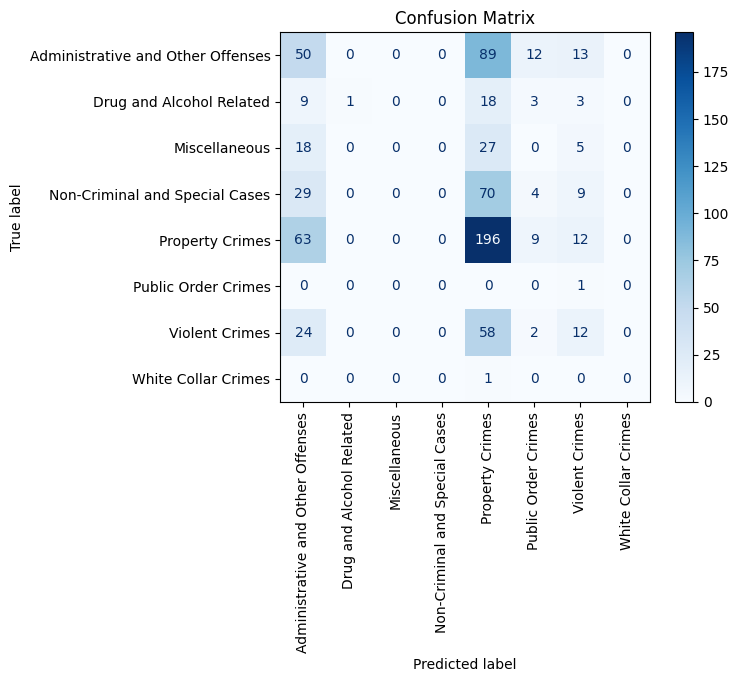

In [ ]:
# Make predictions
y_pred_prob = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Retrieve original class names from LabelEncoder
class_labels = label_encoder.classes_

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
# import numpy as np

In [ ]:
# # Ensure the predictions and true labels are numpy arrays
# all_labels = np.array(all_labels)
# all_preds = np.array(all_preds)

# # Print unique values in predictions and labels
# print("Unique predicted labels:", np.unique(all_preds))
# print("Unique true labels:", np.unique(all_labels))

# # Generate confusion matrix
# conf_matrix = confusion_matrix(all_labels, all_preds)

# # Retrieve original class names from LabelEncoder
# class_labels = label_encoder.classes_

# # Plot confusion matrix with labels and rotated x-axis labels
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
# fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed

# disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
# ax.set_xticks(np.arange(len(class_labels))) # Add this line to set the correct number of ticks

# # plt.xticks(rotation=90)
# plt.title('Confusion Matrix')
# plt.show()

##SHAP EXPLAINER

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 8.2 MB/s eta 0:00:00


In [ ]:
import shap
X_train_reshaped = X_train_reshaped.astype(np.float32)
X_test_reshaped = X_test_reshaped.astype(np.float32)

# Force eager execution for compatibility
tf.compat.v1.disable_eager_execution()

# Get input tensor names
model_inputs = [inp.name for inp in model.inputs]

# Initialize the DeepExplainer with input tensor names
explainer = shap.DeepExplainer(model, X_train_reshaped[:100])

# Compute SHAP values for a subset of the test data
shap_values = explainer.shap_values(X_test_reshaped[:100])  # Using a subset of test data for SHAP values

# Visualize the SHAP values for the first class (assuming multiclass classification)
shap.summary_plot(shap_values[0], X_test_reshaped[:100])

TypeError: DeepExplainer.__init__() got an unexpected keyword argument 'model_inputs'

##Integrating Spatial and Temporal Features Hierarchially

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.metrics import accuracy_score

# # Define the complex model
# class HierarchicalSTModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_lstm_layers=2):
#         super(HierarchicalSTModel, self).__init__()
#         self.convs = nn.Sequential(
#             nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
#             nn.ReLU()
#         )
#         self.lstm_layers = nn.ModuleList([nn.LSTM(hidden_dim, hidden_dim, batch_first=True) for _ in range(num_lstm_layers)])
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         x = x.transpose(1, 2)  # Change shape to (batch_size, input_dim, seq_length) for Conv1d
#         x = self.convs(x)
#         x = x.transpose(1, 2)  # Change shape back to (batch_size, seq_length, hidden_dim) for LSTM
#         for lstm in self.lstm_layers:
#             x, _ = lstm(x)
#         out = self.fc(x[:, -1, :])  # Take the output of the last time step
#         return out

# # Prepare sequences function remains the same
# def prepare_sequences(data, seq_length=10):
#     sequences = []
#     targets = []
#     for i in range(len(data) - seq_length):
#         seq = data[i:i+seq_length]
#         target = data[i+seq_length, -1]
#         sequences.append(seq)
#         targets.append(target)
#     return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.long)

# # Convert data to sequences
# X_train_seq, y_train_seq = prepare_sequences(X_train.values)
# X_test_seq, y_test_seq = prepare_sequences(X_test.values)

# # Create DataLoader
# train_dataset = TensorDataset(X_train_seq, y_train_seq)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_dataset = TensorDataset(X_test_seq, y_test_seq)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# # Model parameters
# input_dim = X_train_seq.shape[2]  # Number of features
# hidden_dim = 128
# output_dim = len(label_encoder.classes_)

# # Instantiate the model
# model = HierarchicalSTModel(input_dim, hidden_dim, output_dim)

# # Training setup
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop with error printing
# num_epochs = 5
# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()

#     # Calculate average training loss
#     train_loss /= len(train_loader)

#     # Calculate training accuracy
#     model.eval()
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for inputs, labels in train_loader:
#             outputs = model(inputs)
#             preds = outputs.argmax(dim=1)
#             all_preds.extend(preds.numpy())
#             all_labels.extend(labels.numpy())
#     train_accuracy = accuracy_score(all_labels, all_preds)

#     # Calculate test accuracy
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             outputs = model(inputs)
#             preds = outputs.argmax(dim=1)
#             all_preds.extend(preds.numpy())
#             all_labels.extend(labels.numpy())
#     test_accuracy = accuracy_score(all_labels, all_preds)

#     print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# # Final evaluation on the test set
# model.eval()
# all_preds = []
# all_labels = []
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         outputs = model(inputs)
#         preds = outputs.argmax(dim=1)
#         all_preds.extend(preds.numpy())
#         all_labels.extend(labels.numpy())
# test_accuracy = accuracy_score(all_labels, all_preds)
# print(f'Final Test Accuracy: {test_accuracy}')